In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import json
import time

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Reload features to ensure we have the latest logic
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
import importlib
import src.features
importlib.reload(src.features)
from src.features import aggregate_user_features

## 1. Load Raw Data & Raw Comparison
We load both Train and Test raw data to compare their fundamental characteristics before any feature engineering.

Loading Raw Data...
Train Raw Shape: (17499636, 19)
Test Raw Shape: (4393179, 19)
Train Raw Shape: (17499636, 19)
Test Raw Shape: (4393179, 19)

--- RAW DATA COMPARISON ---
Train Time Range: 2018-10-01 00:00:01 to 2018-11-20 00:00:00
Test Time Range: 2018-10-01 00:00:06 to 2018-11-20 00:00:00
Train Duration: 49 days
Test Duration: 49 days

--- RAW DATA COMPARISON ---
Train Time Range: 2018-10-01 00:00:01 to 2018-11-20 00:00:00
Test Time Range: 2018-10-01 00:00:06 to 2018-11-20 00:00:00
Train Duration: 49 days
Test Duration: 49 days

Events per User (Train):
count    19140.000000
mean       914.296552
std       1079.652218
min          1.000000
25%        202.000000
50%        537.500000
75%       1213.000000
max      10998.000000
dtype: float64

Events per User (Test):
count      2904.000000
mean       1512.802686
std       12179.711145
min           1.000000
25%         368.000000
50%         835.500000
75%        1781.000000
max      653681.000000
dtype: float64

Events per User (Tra

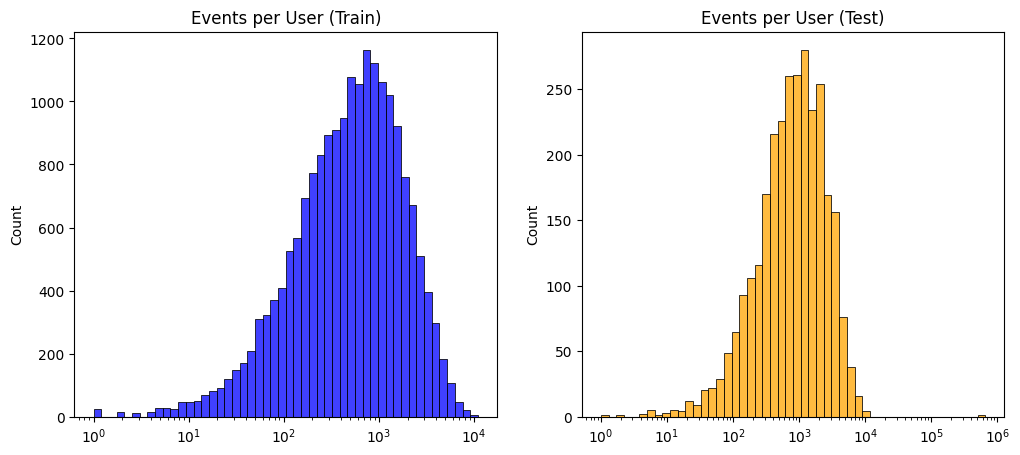


Page Distribution Difference (Train - Test):
                    Train      Test      Diff
page                                         
NextSong         0.816670  0.696947  0.119724
Home             0.036873  0.109674 -0.072801
About            0.001892  0.010126 -0.008234
Thumbs Up        0.045109  0.038093  0.007016
Help             0.005088  0.009253 -0.004165
Add to Playlist  0.023407  0.019905  0.003501
Roll Advert      0.016277  0.012916  0.003361
Add Friend       0.014980  0.012845  0.002135
Logout           0.011697  0.009946  0.001751
Thumbs Down      0.009427  0.008050  0.001376


In [3]:
print("Loading Raw Data...")
train_df_raw = pd.read_parquet('../data/train.parquet')
test_df_raw = pd.read_parquet('../data/test.parquet')

print(f"Train Raw Shape: {train_df_raw.shape}")
print(f"Test Raw Shape: {test_df_raw.shape}")

# Apply basic extraction for timestamps
train_df_raw = extract_user_attributes(train_df_raw)
test_df_raw = extract_user_attributes(test_df_raw)

# --- RAW DATA COMPARISON ---
print("\n--- RAW DATA COMPARISON ---")

# 1. Time Range
print(f"Train Time Range: {train_df_raw['ts'].min()} to {train_df_raw['ts'].max()}")
print(f"Test Time Range: {test_df_raw['ts'].min()} to {test_df_raw['ts'].max()}")
train_duration = (train_df_raw['ts'].max() - train_df_raw['ts'].min()).days
test_duration = (test_df_raw['ts'].max() - test_df_raw['ts'].min()).days
print(f"Train Duration: {train_duration} days")
print(f"Test Duration: {test_duration} days")

# 2. Events per User
train_events_per_user = train_df_raw.groupby('userId').size()
test_events_per_user = test_df_raw.groupby('userId').size()

print("\nEvents per User (Train):")
print(train_events_per_user.describe())
print("\nEvents per User (Test):")
print(test_events_per_user.describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_events_per_user, bins=50, log_scale=True, color='blue', label='Train')  # type: ignore
plt.title('Events per User (Train)')
plt.subplot(1, 2, 2)
sns.histplot(test_events_per_user, bins=50, log_scale=True, color='orange', label='Test')  # type: ignore
plt.title('Events per User (Test)')
plt.show()

# 3. Page Distribution (Activity Type)
train_page_dist = train_df_raw['page'].value_counts(normalize=True)
test_page_dist = test_df_raw['page'].value_counts(normalize=True)

comparison_df = pd.DataFrame({'Train': train_page_dist, 'Test': test_page_dist})
comparison_df['Diff'] = comparison_df['Train'] - comparison_df['Test']
print("\nPage Distribution Difference (Train - Test):")
print(comparison_df.sort_values(by='Diff', key=abs, ascending=False).head(10))

## 2. Single Snapshot Strategy (Temporal Holdout)
To mimic the Test Set (where we predict the future based on a snapshot), we create a **Strict Temporal Cutoff** in our Training Data.

In [4]:
# Define the Cutoff
# We assume the test set covers roughly the last 2 weeks (based on typical churn windows).
# We hide the last 14 days of the training set to use as our "Ground Truth" future.

GLOBAL_MAX_TS = train_df_raw['ts'].max()
PREDICTION_WINDOW_DAYS = 14
CUTOFF_TS = GLOBAL_MAX_TS - pd.Timedelta(days=PREDICTION_WINDOW_DAYS)

print(f"Global Max Timestamp: {GLOBAL_MAX_TS}")
print(f"Training Cutoff Timestamp: {CUTOFF_TS}")

# --- POPULATION FIX ---
# Instead of taking ALL users who ever existed, we only take users ACTIVE in the last 30 days before cutoff.
# This removes "Zombies" (long-churned users) who drag down the activity rates.
ACTIVITY_WINDOW_DAYS = 30
ACTIVITY_START_TS = CUTOFF_TS - pd.Timedelta(days=ACTIVITY_WINDOW_DAYS)

# Identify Active Users in the Window [Cutoff - 30d, Cutoff]
active_events = train_df_raw[(train_df_raw['ts'] > ACTIVITY_START_TS) & (train_df_raw['ts'] <= CUTOFF_TS)]
active_users_pre_cutoff = active_events['userId'].unique()

print(f"Filtering for users active between {ACTIVITY_START_TS} and {CUTOFF_TS}")
print(f"Selected {len(active_users_pre_cutoff)} active users for the snapshot.")

# Create Snapshot DataFrame
snapshot_df = pd.DataFrame({
    'userId': active_users_pre_cutoff,
    'cutoff_ts': CUTOFF_TS
})

print("Aggregating features relative to Cutoff (Train Snapshot)...")
X_snapshot = aggregate_user_features(train_df_raw, snapshot_df=snapshot_df)
X_snapshot = X_snapshot.reset_index(level='cutoff_ts', drop=True)

# Generate Targets (Look ahead)
print("Generating Targets...")
future_events = train_df_raw[train_df_raw['ts'] > CUTOFF_TS]
churners = future_events[future_events['page'] == 'Cancellation Confirmation']['userId'].unique()

X_snapshot['target'] = 0
X_snapshot.loc[X_snapshot.index.isin(churners), 'target'] = 1

print(f"Snapshot Shape: {X_snapshot.shape}")
print(f"Churn Rate: {X_snapshot['target'].mean():.2%}")

Global Max Timestamp: 2018-11-20 00:00:00
Training Cutoff Timestamp: 2018-11-06 00:00:00
Filtering for users active between 2018-10-07 00:00:00 and 2018-11-06 00:00:00
Selected 17686 active users for the snapshot.
Aggregating features relative to Cutoff (Train Snapshot)...
Filtering for users active between 2018-10-07 00:00:00 and 2018-11-06 00:00:00
Selected 17686 active users for the snapshot.
Aggregating features relative to Cutoff (Train Snapshot)...
Generating Targets...
Generating Targets...
Snapshot Shape: (17686, 64)
Churn Rate: 5.64%
Snapshot Shape: (17686, 64)
Churn Rate: 5.64%


## 3. Generate Test Features (for Comparison)
We generate features for the actual Test Set using its end date as the cutoff.

In [5]:
test_max_ts = test_df_raw['ts'].max()
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': test_max_ts
})

print("Aggregating features for Test Set...")
X_test_features = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)
X_test_features = X_test_features.reset_index(level='cutoff_ts', drop=True)

# Align columns
common_cols = [c for c in X_snapshot.columns if c in X_test_features.columns and c != 'target']
X_snapshot_aligned = X_snapshot[common_cols]
X_test_aligned = X_test_features[common_cols]

print(f"Aligned Feature Count: {len(common_cols)}")

Aggregating features for Test Set...
Aligned Feature Count: 63
Aligned Feature Count: 63


## 4. Featured Data Comparison (Train vs Test)
We check if the feature distributions match. Large divergences indicate "Covariate Shift".

Top Feature Divergences (by Mean % Diff):
                     mean_train  std_train  mean_test   std_test  \
activity_trend        -0.673236  17.691139   1.287405  20.213491   
errors_per_song        0.001292   0.003670   0.002988   0.092809   
errors_last_3d         0.044046   0.232342   0.077135   0.739310   
errors_last_1d         0.018942   0.144380   0.032713   0.423188   
errors_last_7d         0.133778   0.425075   0.222452   2.078572   
errors_last_14d        0.272758   0.640814   0.451446   4.020236   
downgrade              0.158261   0.364996   0.256543   0.436800   
errors_last_30d        0.598157   1.047989   0.934917   8.351532   
thumbs_down_last_1d    0.179747   0.649202   0.276171   0.823884   
songs_last_1d         15.864243  43.517963  24.299242  54.572819   

                     mean_diff_pct  std_diff_pct  
activity_trend            2.912265     -0.142577  
errors_per_song          -1.313299    -24.288916  
errors_last_3d           -0.751232     -2.181989  
error

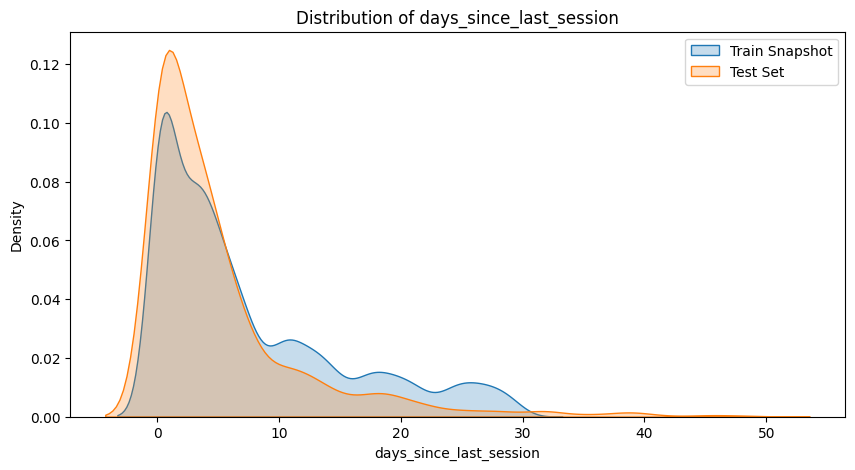

In [6]:
# Compare Mean and Std of key features
train_stats = X_snapshot_aligned.describe().T[['mean', 'std']]
test_stats = X_test_aligned.describe().T[['mean', 'std']]

stats_comparison = train_stats.join(test_stats, lsuffix='_train', rsuffix='_test')
stats_comparison['mean_diff_pct'] = (stats_comparison['mean_train'] - stats_comparison['mean_test']) / (stats_comparison['mean_train'] + 1e-9)
stats_comparison['std_diff_pct'] = (stats_comparison['std_train'] - stats_comparison['std_test']) / (stats_comparison['std_train'] + 1e-9)

print("Top Feature Divergences (by Mean % Diff):")
print(stats_comparison.sort_values(by='mean_diff_pct', key=abs, ascending=False).head(10))

# Plot distribution of a key feature (e.g., days_since_last_session)
feature_to_plot = 'days_since_last_session'
if feature_to_plot in X_snapshot_aligned.columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(X_snapshot_aligned[feature_to_plot], label='Train Snapshot', fill=True)
    sns.kdeplot(X_test_aligned[feature_to_plot], label='Test Set', fill=True)
    plt.title(f"Distribution of {feature_to_plot}")
    plt.legend()
    plt.show()

In [7]:
# Check specifically for our new Time-Invariant Features
new_features = [
    'sessions_per_day', 'thumbs_up_per_day', 'thumbs_down_per_day', 
    'ads_per_day', 'errors_per_day', 'listen_time_per_day'
]
available_new_features = [f for f in new_features if f in stats_comparison.index]

if available_new_features:
    print("\n--- Time-Invariant Feature Divergence ---")
    print(stats_comparison.loc[available_new_features][['mean_train', 'mean_test', 'mean_diff_pct']])
else:
    print("New features not found. Did you reload src.features and re-run aggregation?")


--- Time-Invariant Feature Divergence ---
                     mean_train  mean_test  mean_diff_pct
sessions_per_day       0.127937   0.174390      -0.363085
thumbs_up_per_day      0.352486   0.474569      -0.346348
thumbs_down_per_day    0.098673   0.138226      -0.400842
ads_per_day            0.170104   0.209568      -0.231998
errors_per_day         0.011412   0.017272      -0.513572
listen_time_per_day    7.001141   7.519210      -0.073998


## 5. Train & Evaluate (Sanity Check)
We train a simple XGBoost on the Snapshot data to see if it learns real signal or leakage.

Training on 14148 samples, Validating on 3538 samples

--- Validation Results ---
ROC-AUC: 0.6819
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3339
           1       0.26      0.03      0.05       199

    accuracy                           0.94      3538
   macro avg       0.60      0.51      0.51      3538
weighted avg       0.91      0.94      0.92      3538


--- Validation Results ---
ROC-AUC: 0.6819
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3339
           1       0.26      0.03      0.05       199

    accuracy                           0.94      3538
   macro avg       0.60      0.51      0.51      3538
weighted avg       0.91      0.94      0.92      3538



/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:55:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

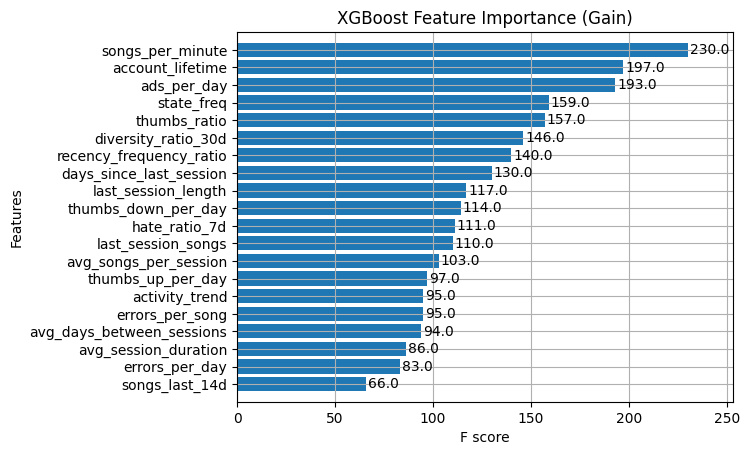

In [8]:
# Split Snapshot into Train/Val
X_train, X_val, y_train, y_val = train_test_split(
    X_snapshot.drop(columns=['target']), X_snapshot['target'], 
    test_size=0.2, random_state=RANDOM_SEED, stratify=X_snapshot['target']
)

# Select numeric only
X_train = X_train.select_dtypes(include=[np.number])
X_val = X_val.select_dtypes(include=[np.number])

print(f"Training on {X_train.shape[0]} samples, Validating on {X_val.shape[0]} samples")

model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_probs)
print("\n--- Validation Results ---")
print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_val, y_pred))

# Feature Importance
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, height=0.8)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [9]:
# --- FEATURE IMPORTANCE ANALYSIS ---
# We analyze which features are actually used by the model to prune noise.
# We use "Gain" (improvement in accuracy) and "Weight" (number of times used).

importance_gain = model.get_booster().get_score(importance_type='gain')
importance_weight = model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Gain': list(importance_gain.values()),
    'Weight': [importance_weight.get(f, 0) for f in importance_gain.keys()]
}).sort_values(by='Gain', ascending=False)

print("\n--- Top 20 Features by Gain (Quality) ---")
print(importance_df.head(20))

print("\n--- Bottom 20 Features (Noise Candidates) ---")
print(importance_df.tail(20))

# Identify features with ZERO importance (not used at all)
all_features = X_train.columns
unused_features = set(all_features) - set(importance_gain.keys())
print(f"\nUnused Features ({len(unused_features)}):")
print(list(unused_features))


--- Top 20 Features by Gain (Quality) ---
                    Feature      Gain  Weight
21     thumbs_down_last_14d  5.940609    41.0
18     unique_songs_last_7d  5.551961     7.0
27     thumbs_down_last_30d  5.109179    62.0
57  recency_frequency_ratio  4.892251   140.0
44      listen_time_per_day  3.596182    58.0
12     unique_songs_last_3d  3.295969    16.0
10      listen_time_last_3d  3.257946    26.0
58         session_velocity  3.229090    10.0
11   unique_artists_last_3d  3.226817    14.0
16      listen_time_last_7d  3.164374    31.0
41      thumbs_down_per_day  3.157168   114.0
32        avg_songs_per_day  3.141670    49.0
30    unique_songs_last_30d  3.029651    21.0
40        thumbs_up_per_day  2.984711    97.0
42              ads_per_day  2.833971   193.0
54        exploration_ratio  2.789147    47.0
25           songs_last_30d  2.758677    32.0
45  days_since_last_session  2.732585   130.0
47     avg_session_duration  2.727414    86.0
29  unique_artists_last_30d  2.709505

In [10]:
print("--- AUTOMATED REPORT FOR AI AGENT ---")
print(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}")

report = {
    "raw_data": {
        "train_duration_days": train_duration,
        "test_duration_days": test_duration,
        "train_events_per_user_mean": train_events_per_user.mean(),
        "test_events_per_user_mean": test_events_per_user.mean(),
    },
    "feature_divergence": stats_comparison.sort_values(by='mean_diff_pct', key=abs, ascending=False).head(5).to_dict(orient='index'),
    "model_performance": {
        "roc_auc": roc_auc,
        "classification_report": classification_report(y_val, y_pred, output_dict=True)
    },
    "top_features": list(pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).head(5).index)
}

print(json.dumps(report, indent=2, default=str))
print("-------------------------------------")

--- AUTOMATED REPORT FOR AI AGENT ---
Date: 2025-12-05 04:55:40
{
  "raw_data": {
    "train_duration_days": 49,
    "test_duration_days": 49,
    "train_events_per_user_mean": 914.2965517241379,
    "test_events_per_user_mean": 1512.8026859504132
  },
  "feature_divergence": {
    "activity_trend": {
      "mean_train": -0.6732357581729967,
      "std_train": 17.691138872720977,
      "mean_test": 1.2874048930867112,
      "std_test": 20.213491235431697,
      "mean_diff_pct": 2.9122645824587354,
      "std_diff_pct": -0.14257716140917917
    },
    "errors_per_song": {
      "mean_train": 0.0012916411834465829,
      "std_train": 0.0036699442670965676,
      "mean_test": 0.0029879539725874205,
      "std_test": 0.09280893689212454,
      "mean_diff_pct": -1.3132993106608233,
      "std_diff_pct": -24.288916083903672
    },
    "errors_last_3d": {
      "mean_train": 0.0440461381883976,
      "std_train": 0.23234226193457133,
      "mean_test": 0.07713498622589532,
      "std_test": 0

In [11]:
# --- LOAD PREVIOUS MODEL (Exp 13 - 0.63630) ---
import joblib

print("\n--- LOADING EXP 13 MODEL ---")
try:
    # Load the Stacking/Voting Model
    model_path = "../models/stacking_model.joblib"
    loaded_model = joblib.load(model_path)
    print(f"Loaded model from {model_path}")
    
    # Load Feature Names
    features_path = "../models/feature_names.joblib"
    feature_names = joblib.load(features_path)
    print(f"Loaded {len(feature_names)} feature names.")
    
    # Check if our current snapshot has these features
    missing_features = set(feature_names) - set(X_snapshot.columns)
    if missing_features:
        print(f"⚠️ Warning: {len(missing_features)} features missing in Sanity Check snapshot:")
        print(list(missing_features)[:5])
        # Fill missing with 0 for analysis
        for f in missing_features:
            X_snapshot[f] = 0
            X_test_features[f] = 0
            
    # Align columns
    X_snapshot_aligned_model = X_snapshot[feature_names]
    X_test_aligned_model = X_test_features[feature_names]
    
    # --- FEATURE DIVERGENCE ANALYSIS (MODEL FEATURES ONLY) ---
    print("\n--- DIVERGENCE ANALYSIS (EXP 13 FEATURES) ---")
    train_stats_m = X_snapshot_aligned_model.describe().T[['mean', 'std']]
    test_stats_m = X_test_aligned_model.describe().T[['mean', 'std']]

    stats_comp_m = train_stats_m.join(test_stats_m, lsuffix='_train', rsuffix='_test')
    stats_comp_m['mean_diff_pct'] = (stats_comp_m['mean_train'] - stats_comp_m['mean_test']) / (stats_comp_m['mean_train'] + 1e-9)
    
    print("Top Divergences in Model Features:")
    print(stats_comp_m.sort_values(by='mean_diff_pct', key=abs, ascending=False).head(10))
    
    # --- PREDICT WITH LOADED MODEL ---
    # We need to preprocess first!
    preprocessor_path = "../models/preprocessor.joblib"
    loaded_preprocessor = joblib.load(preprocessor_path)
    print(f"Loaded preprocessor from {preprocessor_path}")
    
    # Transform
    # Note: Preprocessor expects specific columns. We ensure X_snapshot has them.
    # We might need to be careful if preprocessor was fitted on different columns.
    # Assuming feature_names matches preprocessor expectations.
    
    try:
        # We use the raw snapshot (before alignment) but ensure it has all cols
        # Actually, the pipeline usually includes the preprocessor.
        # Let's check if the loaded model is a Pipeline or VotingClassifier
        
        if hasattr(loaded_model, 'estimators'):
            print("Model is a Voting/Stacking Classifier.")
            # The estimators inside likely have their own pipelines?
            # Or is it Pipeline(preprocessor, Voting)?
            # In Modeling.ipynb, it was VotingClassifier(estimators=[('xgb', Pipeline...), ...])
            # So the VotingClassifier expects RAW features (pandas df).
            
            print("Predicting with loaded model on Sanity Snapshot...")
            y_pred_loaded = loaded_model.predict(X_snapshot_aligned_model)
            y_probs_loaded = loaded_model.predict_proba(X_snapshot_aligned_model)[:, 1]
            
            print(f"Loaded Model ROC-AUC on Sanity Snapshot: {roc_auc_score(X_snapshot['target'], y_probs_loaded):.4f}")
            print(classification_report(X_snapshot['target'], y_pred_loaded))
            
    except Exception as e:
        print(f"Prediction failed: {e}")

except FileNotFoundError:
    print("❌ Model files not found. Did you run Modeling.ipynb to save them?")


--- LOADING EXP 13 MODEL ---
Loaded model from ../models/stacking_model.joblib
Loaded 63 feature names.

--- DIVERGENCE ANALYSIS (EXP 13 FEATURES) ---
Loaded model from ../models/stacking_model.joblib
Loaded 63 feature names.

--- DIVERGENCE ANALYSIS (EXP 13 FEATURES) ---
Top Divergences in Model Features:
                     mean_train  std_train  mean_test   std_test  \
activity_trend        -0.673236  17.691139   1.287405  20.213491   
errors_per_song        0.001292   0.003670   0.002988   0.092809   
errors_last_3d         0.044046   0.232342   0.077135   0.739310   
errors_last_1d         0.018942   0.144380   0.032713   0.423188   
errors_last_7d         0.133778   0.425075   0.222452   2.078572   
errors_last_14d        0.272758   0.640814   0.451446   4.020236   
downgrade              0.158261   0.364996   0.256543   0.436800   
errors_last_30d        0.598157   1.047989   0.934917   8.351532   
thumbs_down_last_1d    0.179747   0.649202   0.276171   0.823884   
songs_last_

/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Loaded Model ROC-AUC on Sanity Snapshot: 0.8259
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     16689
           1       0.31      0.34      0.32       997

    accuracy                           0.92     17686
   macro avg       0.64      0.65      0.64     17686
weighted avg       0.92      0.92      0.92     17686



/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
